In [4]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [5]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

In [6]:
train_or_load_pretrained = "train" # Set this to "train" if you want to train a new network
pretrained_modelname = "model_time"
num_epochs = 500
batch_size = 32
batch_size_val = 32
validation_split = .3
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'raw'
modeltype = 'wingbeatraw' #'inception' #wingbeatraw
normalize = ""#"sample"

train_df = pd.read_parquet('../data_created/suzmel_traindf_plus_extradf.parquet') #suzmel_train.parquet')
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')

transforms_list_train = [Bandpass(lowcut=140, highcut=1500), RandomRoll(p=1.) ,RandomFlip(), RandomNoise(p=7.)]#, RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass(lowcut=140, highcut=1500)]


In [ ]:
X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42)#, stratify=y)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [ ]:
plot_wingbeat(train_dataset, idx=2)

In [ ]:
outs = 2
if modeltype == 'wingbeatraw':
    model = DrosophilaNetRAW(outputs=outs, dropout_p=.2)
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=outs))

class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(label_smoothing=0.35, weight=torch.Tensor(weight).cuda())
elif outs == 2:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.35, weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular")
# early_stopping = EarlyStopping(patience=10, verbose=1)

## Training

In [7]:
if train_or_load_pretrained == 'train':
    # Choosing whether to train on a gpu
    train_on_gpu = torch.cuda.is_available()
    print(f'Train on gpu: {train_on_gpu}')# Number of gpus
    model = model.to('cuda', dtype=torch.float)

    results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
    best_valacc = 0
    # Model training
    for epoch in range(num_epochs):
        # Going through the training set
        correct_train = 0
        model.train()
        for x_batch,y_batch,_,_ in tqdm(train_dataloader, desc='Training..\t'):        
            y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
            x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
            for param in model.parameters():
                param.grad = None
            pred = model(x_batch)
            if outs == 1:
                y_batch = y_batch.type(torch.FloatTensor).cuda()
                correct_train += ((pred>0.5).int().squeeze() == y_batch.squeeze()).float().sum().item()
                loss = criterion(pred, y_batch.unsqueeze(1))
            elif outs == 2:
                y_batch = y_batch.type(torch.LongTensor).cuda()
                correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
                loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
        train_accuracy = correct_train / len(train_dataset) * 100.

        # Going through the validation set
        correct_valid = 0
        model.eval()
        for x_batch,y_batch,_,_ in tqdm(valid_dataloader, desc='Validating..\t'):
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
            pred = model(x_batch)
            if outs == 1:
                y_batch = y_batch.type(torch.FloatTensor).cuda()
                correct_valid += ((pred>0.5).int().squeeze().cuda() == y_batch.squeeze()).float().sum().item()
                val_loss = criterion(pred, y_batch.unsqueeze(1))
            elif outs == 2:
                y_batch = y_batch.type(torch.LongTensor).cuda()
                correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
                val_loss = criterion(pred, y_batch)
        valid_accuracy = correct_valid / len(valid_dataset) * 100.

        scheduler.step()
    #     early_stopping(val_loss, model)
    #     if early_stopping.early_stop:
    #         print("Early stopping")
    #         break

            # Printing results
        print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")

        is_best = valid_accuracy > best_valacc
        if is_best:
            print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
        best_valacc = max(valid_accuracy, best_valacc)
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_valacc': best_valacc,
            'loss': results['loss'].append(loss.detach().cpu()),
            'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
            'train_accuracy': results['train_accuracy'].append(train_accuracy),
            'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
            'optimizer' : optimizer.state_dict(),
        }, is_best, "model_time")
elif train_or_load_pretrained == 'load':
    model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/{pretrained_modelname}.pth.tar', model, optimizer)
    model = model.to('cuda', dtype=torch.float)
else:
    print("Set train_or_load_pretrained to either \'train\' or \'load\'")

Training..	:   0%|          | 0/1433 [00:00<?, ?it/s]

Train on gpu: True


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 105.85it/s]


Epoch 0: train_acc: 82.4% loss: 0.5860946,  val_loss: 0.7216274 val_acc: 83.8%
Validation accuracy improved from 0.00 to 83.84. Saving model..


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.68it/s]


Epoch 1: train_acc: 87.2% loss: 0.6835896,  val_loss: 0.7247103 val_acc: 92.7%
Validation accuracy improved from 83.84 to 92.71. Saving model..


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.79it/s]


Epoch 2: train_acc: 88.9% loss: 0.5654218,  val_loss: 0.1920846 val_acc: 90.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.75it/s]


Epoch 3: train_acc: 89.7% loss: 0.4914647,  val_loss: 0.8757069 val_acc: 92.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.01it/s]


Epoch 4: train_acc: 90.3% loss: 0.8679563,  val_loss: 0.7513365 val_acc: 89.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.86it/s]


Epoch 5: train_acc: 90.8% loss: 0.4667176,  val_loss: 0.7288598 val_acc: 87.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 111.36it/s]


Epoch 6: train_acc: 91.1% loss: 0.8617954,  val_loss: 0.7841400 val_acc: 95.6%
Validation accuracy improved from 92.71 to 95.65. Saving model..


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.12it/s]


Epoch 7: train_acc: 91.6% loss: 0.8695650,  val_loss: 0.7400314 val_acc: 95.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.64it/s]


Epoch 8: train_acc: 91.9% loss: 0.4741155,  val_loss: 0.1919886 val_acc: 95.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.83it/s]


Epoch 9: train_acc: 92.1% loss: 0.4291568,  val_loss: 0.7420208 val_acc: 94.8%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 106.93it/s]


Epoch 10: train_acc: 92.3% loss: 0.4649035,  val_loss: 0.1876428 val_acc: 96.2%
Validation accuracy improved from 95.65 to 96.22. Saving model..


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.35it/s]


Epoch 11: train_acc: 92.5% loss: 0.4293602,  val_loss: 0.1902987 val_acc: 90.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.04it/s]


Epoch 12: train_acc: 92.6% loss: 0.4150984,  val_loss: 0.7270482 val_acc: 92.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.55it/s]


Epoch 13: train_acc: 92.8% loss: 0.4337543,  val_loss: 0.2259663 val_acc: 94.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.82it/s]


Epoch 14: train_acc: 93.0% loss: 0.5434812,  val_loss: 0.7432495 val_acc: 92.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.92it/s]


Epoch 15: train_acc: 93.2% loss: 0.5525297,  val_loss: 0.2714846 val_acc: 88.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.28it/s]


Epoch 16: train_acc: 93.2% loss: 0.5735267,  val_loss: 0.7184219 val_acc: 94.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.39it/s]


Epoch 17: train_acc: 93.4% loss: 0.8622950,  val_loss: 0.7672280 val_acc: 94.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.90it/s]


Epoch 18: train_acc: 93.5% loss: 0.3458067,  val_loss: 0.7574977 val_acc: 91.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.34it/s]


Epoch 19: train_acc: 93.5% loss: 0.3401090,  val_loss: 0.7768329 val_acc: 95.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.85it/s]


Epoch 20: train_acc: 93.7% loss: 0.4136126,  val_loss: 0.1831816 val_acc: 95.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.57it/s]


Epoch 21: train_acc: 93.6% loss: 0.5523718,  val_loss: 0.1977030 val_acc: 95.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.73it/s]


Epoch 22: train_acc: 93.9% loss: 0.5542839,  val_loss: 0.7184800 val_acc: 92.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.52it/s]


Epoch 23: train_acc: 93.8% loss: 0.6314416,  val_loss: 0.1865723 val_acc: 96.9%
Validation accuracy improved from 96.22 to 96.86. Saving model..


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.35it/s]


Epoch 24: train_acc: 94.1% loss: 0.4148675,  val_loss: 0.7219095 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.96it/s]


Epoch 25: train_acc: 93.9% loss: 0.4963125,  val_loss: 0.2579224 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.14it/s]


Epoch 26: train_acc: 94.1% loss: 0.8283530,  val_loss: 0.7634638 val_acc: 94.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.92it/s]


Epoch 27: train_acc: 94.3% loss: 0.5471729,  val_loss: 0.7485929 val_acc: 92.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.49it/s]


Epoch 28: train_acc: 94.3% loss: 0.4472058,  val_loss: 0.7228042 val_acc: 97.0%
Validation accuracy improved from 96.86 to 96.98. Saving model..


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.76it/s]


Epoch 29: train_acc: 94.5% loss: 0.4454621,  val_loss: 0.7320552 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.34it/s]


Epoch 30: train_acc: 94.5% loss: 0.5399283,  val_loss: 0.7216036 val_acc: 89.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.51it/s]


Epoch 31: train_acc: 94.4% loss: 0.3541811,  val_loss: 0.7522578 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.31it/s]


Epoch 32: train_acc: 94.4% loss: 0.5696069,  val_loss: 0.3427256 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.28it/s]


Epoch 33: train_acc: 94.5% loss: 0.6377434,  val_loss: 0.7769954 val_acc: 94.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 111.05it/s]


Epoch 34: train_acc: 94.6% loss: 0.4454932,  val_loss: 0.7520479 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.15it/s]


Epoch 35: train_acc: 94.6% loss: 0.4208938,  val_loss: 0.8873688 val_acc: 95.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.38it/s]


Epoch 36: train_acc: 94.6% loss: 0.4301223,  val_loss: 0.3511855 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.85it/s]


Epoch 37: train_acc: 94.8% loss: 0.5251963,  val_loss: 0.2077639 val_acc: 92.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.04it/s]


Epoch 38: train_acc: 94.8% loss: 0.5447838,  val_loss: 0.7581102 val_acc: 94.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.60it/s]


Epoch 39: train_acc: 94.9% loss: 0.5452756,  val_loss: 0.1845436 val_acc: 91.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.33it/s]


Epoch 40: train_acc: 94.9% loss: 0.4322017,  val_loss: 0.7196238 val_acc: 94.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.31it/s]


Epoch 41: train_acc: 95.0% loss: 0.7884680,  val_loss: 0.7384396 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.44it/s]


Epoch 42: train_acc: 95.1% loss: 0.5502206,  val_loss: 0.2277973 val_acc: 94.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.02it/s]


Epoch 43: train_acc: 95.1% loss: 0.4821477,  val_loss: 0.7457879 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.78it/s]


Epoch 44: train_acc: 95.1% loss: 0.4230910,  val_loss: 0.7450007 val_acc: 97.2%
Validation accuracy improved from 96.98 to 97.17. Saving model..


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.37it/s]


Epoch 45: train_acc: 95.1% loss: 0.4374529,  val_loss: 0.7313249 val_acc: 90.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.02it/s]


Epoch 46: train_acc: 95.2% loss: 0.5341012,  val_loss: 0.7186115 val_acc: 94.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.52it/s]


Epoch 47: train_acc: 95.1% loss: 0.4788558,  val_loss: 0.2333124 val_acc: 97.5%
Validation accuracy improved from 97.17 to 97.52. Saving model..


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.01it/s]


Epoch 48: train_acc: 95.2% loss: 0.4558840,  val_loss: 0.7289198 val_acc: 95.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.38it/s]


Epoch 49: train_acc: 95.4% loss: 0.3521798,  val_loss: 0.1831757 val_acc: 94.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.25it/s]


Epoch 50: train_acc: 95.3% loss: 0.4132665,  val_loss: 0.8145455 val_acc: 95.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.68it/s]


Epoch 51: train_acc: 95.4% loss: 0.4274888,  val_loss: 0.7222941 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.12it/s]


Epoch 52: train_acc: 95.5% loss: 0.7804535,  val_loss: 0.7231284 val_acc: 95.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.88it/s]


Epoch 53: train_acc: 95.3% loss: 0.5515146,  val_loss: 0.7184218 val_acc: 96.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.29it/s]


Epoch 54: train_acc: 95.5% loss: 0.4207936,  val_loss: 0.7216144 val_acc: 95.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.25it/s]


Epoch 55: train_acc: 95.5% loss: 0.5917754,  val_loss: 0.1836626 val_acc: 96.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.98it/s]


Epoch 56: train_acc: 95.5% loss: 0.4295375,  val_loss: 0.7333168 val_acc: 94.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.84it/s]


Epoch 57: train_acc: 95.4% loss: 0.4382361,  val_loss: 0.7198364 val_acc: 94.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.01it/s]


Epoch 58: train_acc: 95.6% loss: 0.5487289,  val_loss: 0.1928751 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.31it/s]


Epoch 59: train_acc: 95.7% loss: 0.5364097,  val_loss: 0.7301714 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.20it/s]


Epoch 60: train_acc: 95.8% loss: 0.4045984,  val_loss: 0.7185534 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.74it/s]


Epoch 61: train_acc: 95.8% loss: 0.4035323,  val_loss: 0.7207811 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.50it/s]


Epoch 62: train_acc: 95.7% loss: 0.4662449,  val_loss: 0.7192074 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.97it/s]


Epoch 63: train_acc: 95.8% loss: 0.3373753,  val_loss: 0.1883002 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.58it/s]


Epoch 64: train_acc: 95.9% loss: 0.3462758,  val_loss: 0.7598916 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.50it/s]


Epoch 65: train_acc: 95.9% loss: 0.5436175,  val_loss: 0.7198194 val_acc: 95.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.55it/s]


Epoch 66: train_acc: 95.9% loss: 0.5399823,  val_loss: 0.7196156 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.49it/s]


Epoch 67: train_acc: 95.7% loss: 0.5413764,  val_loss: 0.1839871 val_acc: 95.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.14it/s]


Epoch 68: train_acc: 96.0% loss: 0.6144808,  val_loss: 0.1936701 val_acc: 93.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.53it/s]


Epoch 69: train_acc: 96.1% loss: 0.5565197,  val_loss: 0.7355676 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.22it/s]


Epoch 70: train_acc: 96.1% loss: 0.4160146,  val_loss: 0.7432339 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.66it/s]


Epoch 71: train_acc: 96.2% loss: 0.4726816,  val_loss: 0.7296052 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 111.06it/s]


Epoch 72: train_acc: 96.0% loss: 0.3448567,  val_loss: 0.7234134 val_acc: 95.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.83it/s]


Epoch 73: train_acc: 96.1% loss: 0.3323736,  val_loss: 0.1907029 val_acc: 95.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.74it/s]


Epoch 74: train_acc: 96.1% loss: 0.5400705,  val_loss: 0.7187359 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.55it/s]


Epoch 75: train_acc: 96.2% loss: 0.3769651,  val_loss: 0.7281352 val_acc: 95.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.77it/s]


Epoch 76: train_acc: 96.2% loss: 0.4275629,  val_loss: 0.7191638 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.84it/s]


Epoch 77: train_acc: 96.3% loss: 0.3965000,  val_loss: 0.7236145 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 111.02it/s]


Epoch 78: train_acc: 96.2% loss: 0.4439009,  val_loss: 0.2144006 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.76it/s]


Epoch 79: train_acc: 96.4% loss: 0.4179515,  val_loss: 0.7202972 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.79it/s]


Epoch 80: train_acc: 96.4% loss: 0.3395807,  val_loss: 0.7195504 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.79it/s]


Epoch 81: train_acc: 96.3% loss: 0.7562494,  val_loss: 0.1855946 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.33it/s]


Epoch 82: train_acc: 96.3% loss: 0.5056940,  val_loss: 0.1955229 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.53it/s]


Epoch 83: train_acc: 96.3% loss: 0.4144873,  val_loss: 0.7199177 val_acc: 94.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.64it/s]


Epoch 84: train_acc: 96.5% loss: 0.7501800,  val_loss: 0.7419407 val_acc: 95.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.48it/s]


Epoch 85: train_acc: 96.4% loss: 0.5428262,  val_loss: 0.1963287 val_acc: 93.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.91it/s]


Epoch 86: train_acc: 96.3% loss: 0.5446651,  val_loss: 0.4090015 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.36it/s]


Epoch 87: train_acc: 96.5% loss: 0.5385908,  val_loss: 0.7261702 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.27it/s]


Epoch 88: train_acc: 96.5% loss: 0.5745154,  val_loss: 0.7186480 val_acc: 97.6%
Validation accuracy improved from 97.52 to 97.62. Saving model..


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.20it/s]


Epoch 89: train_acc: 96.6% loss: 0.4493270,  val_loss: 0.7545614 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.38it/s]


Epoch 90: train_acc: 96.6% loss: 0.4212323,  val_loss: 0.7406082 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.08it/s]


Epoch 91: train_acc: 96.6% loss: 0.6935474,  val_loss: 0.1884285 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.34it/s]


Epoch 92: train_acc: 96.6% loss: 0.4313650,  val_loss: 0.7376253 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.49it/s]


Epoch 93: train_acc: 96.5% loss: 0.7505352,  val_loss: 0.7632837 val_acc: 93.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.59it/s]


Epoch 94: train_acc: 96.8% loss: 0.4488981,  val_loss: 0.7821008 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 111.06it/s]


Epoch 95: train_acc: 96.6% loss: 0.3310171,  val_loss: 0.7413176 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.66it/s]


Epoch 96: train_acc: 96.8% loss: 0.5551278,  val_loss: 0.2401881 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.16it/s]


Epoch 97: train_acc: 96.7% loss: 1.0126135,  val_loss: 0.1838271 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.40it/s]


Epoch 98: train_acc: 96.7% loss: 0.7841061,  val_loss: 0.7298682 val_acc: 94.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.85it/s]


Epoch 99: train_acc: 96.7% loss: 0.3923091,  val_loss: 0.1831570 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.34it/s]


Epoch 100: train_acc: 96.9% loss: 0.4178389,  val_loss: 0.7376878 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.07it/s]


Epoch 101: train_acc: 97.0% loss: 0.3472233,  val_loss: 0.7186097 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.07it/s]


Epoch 102: train_acc: 96.8% loss: 0.4133767,  val_loss: 0.7384481 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.44it/s]


Epoch 103: train_acc: 96.9% loss: 0.4577408,  val_loss: 0.7184211 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.51it/s]


Epoch 104: train_acc: 96.8% loss: 0.4686322,  val_loss: 0.7353177 val_acc: 94.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.22it/s]


Epoch 105: train_acc: 96.7% loss: 0.5778035,  val_loss: 0.1840889 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.16it/s]


Epoch 106: train_acc: 97.0% loss: 0.5494292,  val_loss: 0.7466326 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.00it/s]


Epoch 107: train_acc: 97.0% loss: 0.5186946,  val_loss: 0.7389272 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.99it/s]


Epoch 108: train_acc: 97.0% loss: 0.8505773,  val_loss: 0.1850506 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.26it/s]


Epoch 109: train_acc: 97.2% loss: 0.4441851,  val_loss: 0.7410790 val_acc: 95.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.99it/s]


Epoch 110: train_acc: 97.1% loss: 0.4574564,  val_loss: 0.8184272 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.16it/s]


Epoch 111: train_acc: 96.9% loss: 0.3906584,  val_loss: 0.7288107 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.44it/s]


Epoch 112: train_acc: 97.1% loss: 0.3675855,  val_loss: 0.2691866 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.01it/s]


Epoch 113: train_acc: 97.0% loss: 0.7611982,  val_loss: 0.7579991 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.59it/s]


Epoch 114: train_acc: 97.2% loss: 0.7287944,  val_loss: 0.2012216 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.79it/s]


Epoch 115: train_acc: 97.2% loss: 0.4193527,  val_loss: 0.7193017 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.49it/s]


Epoch 116: train_acc: 97.3% loss: 0.3411095,  val_loss: 0.7306468 val_acc: 95.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.02it/s]


Epoch 117: train_acc: 97.3% loss: 0.5350116,  val_loss: 0.2055349 val_acc: 95.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.36it/s]


Epoch 118: train_acc: 97.2% loss: 0.5979964,  val_loss: 0.7416995 val_acc: 98.0%
Validation accuracy improved from 97.62 to 98.01. Saving model..


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.57it/s]


Epoch 119: train_acc: 97.3% loss: 0.7279068,  val_loss: 0.1977590 val_acc: 94.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.22it/s]


Epoch 120: train_acc: 97.3% loss: 0.6400446,  val_loss: 0.7228163 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.74it/s]


Epoch 121: train_acc: 97.3% loss: 0.4134103,  val_loss: 0.7203757 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.48it/s]


Epoch 122: train_acc: 97.3% loss: 0.5565737,  val_loss: 0.7194619 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.15it/s]


Epoch 123: train_acc: 97.3% loss: 0.5345474,  val_loss: 0.7383887 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.29it/s]


Epoch 124: train_acc: 97.4% loss: 0.4116811,  val_loss: 0.7232882 val_acc: 92.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.84it/s]


Epoch 125: train_acc: 97.4% loss: 0.4330848,  val_loss: 0.7242935 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.06it/s]


Epoch 126: train_acc: 97.4% loss: 0.4235283,  val_loss: 0.7346126 val_acc: 95.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.20it/s]


Epoch 127: train_acc: 97.4% loss: 0.3979233,  val_loss: 0.1894327 val_acc: 91.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.15it/s]


Epoch 128: train_acc: 97.5% loss: 0.4633299,  val_loss: 0.7282265 val_acc: 92.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.46it/s]


Epoch 129: train_acc: 97.4% loss: 0.5708691,  val_loss: 0.8176404 val_acc: 94.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.73it/s]


Epoch 130: train_acc: 97.5% loss: 0.5447103,  val_loss: 0.7271107 val_acc: 93.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.35it/s]


Epoch 131: train_acc: 97.5% loss: 0.4169981,  val_loss: 0.1918251 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.47it/s]


Epoch 132: train_acc: 97.5% loss: 0.5424209,  val_loss: 0.7257828 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.46it/s]


Epoch 133: train_acc: 97.5% loss: 0.7678247,  val_loss: 0.7184253 val_acc: 94.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.79it/s]


Epoch 134: train_acc: 97.6% loss: 0.5411409,  val_loss: 0.2338398 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.91it/s]


Epoch 135: train_acc: 97.5% loss: 0.4786859,  val_loss: 0.2016748 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.43it/s]


Epoch 136: train_acc: 97.6% loss: 0.4158335,  val_loss: 0.1845269 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.21it/s]


Epoch 137: train_acc: 97.7% loss: 0.4201705,  val_loss: 0.7265699 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.82it/s]


Epoch 138: train_acc: 97.7% loss: 0.3596528,  val_loss: 0.8478413 val_acc: 98.0%
Validation accuracy improved from 98.01 to 98.03. Saving model..


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.95it/s]


Epoch 139: train_acc: 97.7% loss: 0.4414141,  val_loss: 0.7189369 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.51it/s]


Epoch 140: train_acc: 97.6% loss: 0.4237894,  val_loss: 0.1908599 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.22it/s]


Epoch 141: train_acc: 97.7% loss: 0.3975287,  val_loss: 0.7735875 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.61it/s]


Epoch 142: train_acc: 97.8% loss: 0.3660381,  val_loss: 0.7184367 val_acc: 94.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.81it/s]


Epoch 143: train_acc: 97.6% loss: 0.5798508,  val_loss: 0.7431486 val_acc: 96.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.83it/s]


Epoch 144: train_acc: 97.8% loss: 0.7334492,  val_loss: 0.7325279 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.56it/s]


Epoch 145: train_acc: 97.8% loss: 0.4190868,  val_loss: 0.7297791 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.58it/s]


Epoch 146: train_acc: 97.9% loss: 0.8587928,  val_loss: 0.8151190 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.75it/s]


Epoch 147: train_acc: 97.9% loss: 0.3435940,  val_loss: 0.8194265 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.05it/s]


Epoch 148: train_acc: 97.9% loss: 0.4448653,  val_loss: 0.7209139 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.85it/s]


Epoch 149: train_acc: 97.8% loss: 0.8331340,  val_loss: 0.7233586 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.85it/s]


Epoch 150: train_acc: 97.9% loss: 0.2922694,  val_loss: 0.2280659 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.11it/s]


Epoch 151: train_acc: 97.9% loss: 0.4211507,  val_loss: 0.1831537 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.72it/s]


Epoch 152: train_acc: 97.9% loss: 0.4292417,  val_loss: 0.7899973 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.48it/s]


Epoch 153: train_acc: 97.9% loss: 0.9341101,  val_loss: 0.7198737 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.16it/s]


Epoch 154: train_acc: 97.8% loss: 0.4455110,  val_loss: 0.7212827 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.50it/s]


Epoch 155: train_acc: 97.8% loss: 0.3891800,  val_loss: 0.2195977 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.03it/s]


Epoch 156: train_acc: 98.0% loss: 0.3382718,  val_loss: 0.7281609 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.94it/s]


Epoch 157: train_acc: 98.0% loss: 0.3494295,  val_loss: 0.7192107 val_acc: 94.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.16it/s]


Epoch 158: train_acc: 98.0% loss: 0.3365306,  val_loss: 0.1835995 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.03it/s]


Epoch 159: train_acc: 98.1% loss: 0.5059100,  val_loss: 0.7409225 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.49it/s]


Epoch 160: train_acc: 97.9% loss: 0.4159147,  val_loss: 0.7280535 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.61it/s]


Epoch 161: train_acc: 97.9% loss: 0.7798750,  val_loss: 0.2024390 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.70it/s]


Epoch 162: train_acc: 98.0% loss: 0.4218918,  val_loss: 0.1854495 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.56it/s]


Epoch 163: train_acc: 98.1% loss: 0.5619570,  val_loss: 0.7189994 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 106.55it/s]


Epoch 164: train_acc: 98.1% loss: 0.5406792,  val_loss: 0.7618992 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.95it/s]


Epoch 165: train_acc: 98.1% loss: 0.3377514,  val_loss: 0.7665123 val_acc: 98.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.26it/s]


Epoch 166: train_acc: 98.1% loss: 0.4130607,  val_loss: 0.7192261 val_acc: 95.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.32it/s]


Epoch 167: train_acc: 98.3% loss: 0.5375398,  val_loss: 0.2194109 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.37it/s]


Epoch 168: train_acc: 98.2% loss: 0.4303919,  val_loss: 0.7300177 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.88it/s]


Epoch 169: train_acc: 98.2% loss: 0.5357899,  val_loss: 0.7263297 val_acc: 95.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.31it/s]


Epoch 170: train_acc: 98.2% loss: 0.3403519,  val_loss: 0.7317991 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.34it/s]


Epoch 171: train_acc: 98.2% loss: 0.5465673,  val_loss: 0.2334315 val_acc: 93.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.40it/s]


Epoch 172: train_acc: 98.2% loss: 0.5456344,  val_loss: 0.7301761 val_acc: 95.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.60it/s]


Epoch 173: train_acc: 98.3% loss: 0.7894521,  val_loss: 0.7185805 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.81it/s]


Epoch 174: train_acc: 98.3% loss: 0.4177292,  val_loss: 0.7184588 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.73it/s]


Epoch 175: train_acc: 98.3% loss: 0.5669923,  val_loss: 0.2174711 val_acc: 92.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.80it/s]


Epoch 176: train_acc: 98.3% loss: 0.5514557,  val_loss: 0.7185243 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.83it/s]


Epoch 177: train_acc: 98.3% loss: 0.5659825,  val_loss: 0.7190109 val_acc: 95.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.89it/s]


Epoch 178: train_acc: 98.3% loss: 0.3404895,  val_loss: 0.7309861 val_acc: 94.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.52it/s]


Epoch 179: train_acc: 98.4% loss: 0.7598677,  val_loss: 0.7186347 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.89it/s]


Epoch 180: train_acc: 98.4% loss: 0.7705464,  val_loss: 0.7651799 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.21it/s]


Epoch 181: train_acc: 98.4% loss: 0.5613877,  val_loss: 0.7657855 val_acc: 96.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.79it/s]


Epoch 182: train_acc: 98.4% loss: 0.5676682,  val_loss: 0.7207937 val_acc: 95.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.74it/s]


Epoch 183: train_acc: 98.4% loss: 0.5710290,  val_loss: 0.7261292 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.45it/s]


Epoch 184: train_acc: 98.3% loss: 0.2860693,  val_loss: 0.1831926 val_acc: 95.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.00it/s]


Epoch 185: train_acc: 98.3% loss: 0.3467738,  val_loss: 0.7215830 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.21it/s]


Epoch 186: train_acc: 98.4% loss: 0.3674978,  val_loss: 0.2154329 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.10it/s]


Epoch 187: train_acc: 98.5% loss: 0.4217007,  val_loss: 0.7190783 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.06it/s]


Epoch 188: train_acc: 98.5% loss: 0.5499887,  val_loss: 0.7424342 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.90it/s]


Epoch 189: train_acc: 98.5% loss: 0.5765280,  val_loss: 0.7196816 val_acc: 95.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.18it/s]


Epoch 190: train_acc: 98.5% loss: 0.5763636,  val_loss: 0.1908428 val_acc: 94.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.94it/s]


Epoch 191: train_acc: 98.5% loss: 0.9034138,  val_loss: 0.7991072 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.72it/s]


Epoch 192: train_acc: 98.4% loss: 0.3557342,  val_loss: 0.7827623 val_acc: 90.9%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 96.21it/s] 


Epoch 193: train_acc: 98.4% loss: 0.4197504,  val_loss: 0.2146986 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 103.40it/s]


Epoch 194: train_acc: 98.5% loss: 0.4074064,  val_loss: 0.1837462 val_acc: 98.0%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.41it/s]


Epoch 195: train_acc: 98.5% loss: 0.5685337,  val_loss: 0.7482671 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.87it/s]


Epoch 196: train_acc: 98.4% loss: 0.4388144,  val_loss: 0.1840456 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.53it/s]


Epoch 197: train_acc: 98.4% loss: 0.6123933,  val_loss: 0.7197663 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.89it/s]


Epoch 198: train_acc: 98.6% loss: 0.5554085,  val_loss: 0.7187601 val_acc: 96.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.43it/s]


Epoch 199: train_acc: 98.5% loss: 0.5339981,  val_loss: 0.7186894 val_acc: 95.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.82it/s]


Epoch 200: train_acc: 98.7% loss: 0.5452847,  val_loss: 0.7523720 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.94it/s]


Epoch 201: train_acc: 98.6% loss: 0.5350773,  val_loss: 0.2238443 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.73it/s]


Epoch 202: train_acc: 98.6% loss: 0.4215474,  val_loss: 0.7451703 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.43it/s]


Epoch 203: train_acc: 98.7% loss: 0.3321451,  val_loss: 0.2673995 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.99it/s]


Epoch 204: train_acc: 98.7% loss: 0.7509018,  val_loss: 0.1831466 val_acc: 95.2%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.05it/s]


Epoch 205: train_acc: 98.7% loss: 0.7264200,  val_loss: 0.7344618 val_acc: 97.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.52it/s]


Epoch 206: train_acc: 98.7% loss: 0.5661508,  val_loss: 0.7258795 val_acc: 96.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.05it/s]


Epoch 207: train_acc: 98.9% loss: 0.5610704,  val_loss: 0.7190655 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.03it/s]


Epoch 208: train_acc: 98.8% loss: 0.5399287,  val_loss: 0.1996149 val_acc: 98.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.88it/s]


Epoch 209: train_acc: 98.7% loss: 0.5636511,  val_loss: 0.7188633 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.46it/s]


Epoch 210: train_acc: 98.8% loss: 0.4140191,  val_loss: 0.7188163 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.59it/s]


Epoch 211: train_acc: 98.7% loss: 0.5901705,  val_loss: 0.2659942 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.67it/s]


Epoch 212: train_acc: 98.4% loss: 0.7710885,  val_loss: 0.7200233 val_acc: 95.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.94it/s]


Epoch 213: train_acc: 98.6% loss: 0.5494020,  val_loss: 0.7505509 val_acc: 92.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.17it/s]


Epoch 214: train_acc: 98.7% loss: 0.4265293,  val_loss: 0.8266436 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.00it/s]


Epoch 215: train_acc: 98.7% loss: 0.5345730,  val_loss: 0.7199798 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.60it/s]


Epoch 216: train_acc: 98.8% loss: 0.5429175,  val_loss: 0.7533131 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.57it/s]


Epoch 217: train_acc: 98.8% loss: 0.3390034,  val_loss: 0.7184612 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.74it/s]


Epoch 218: train_acc: 98.8% loss: 0.4244651,  val_loss: 0.7209183 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.59it/s]


Epoch 219: train_acc: 98.8% loss: 0.4154667,  val_loss: 0.7241358 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.82it/s]


Epoch 220: train_acc: 98.9% loss: 0.9031867,  val_loss: 0.7200857 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.03it/s]


Epoch 221: train_acc: 98.7% loss: 0.4248009,  val_loss: 0.7371324 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.74it/s]


Epoch 222: train_acc: 98.8% loss: 0.4162061,  val_loss: 0.7301797 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 99.36it/s] 


Epoch 223: train_acc: 98.8% loss: 0.8837543,  val_loss: 0.7185882 val_acc: 95.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.69it/s]


Epoch 224: train_acc: 98.9% loss: 0.4158830,  val_loss: 0.7233943 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.56it/s]


Epoch 225: train_acc: 98.8% loss: 0.5317490,  val_loss: 0.7305454 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.10it/s]


Epoch 226: train_acc: 99.0% loss: 0.7323592,  val_loss: 0.7199952 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.22it/s]


Epoch 227: train_acc: 98.9% loss: 0.5890833,  val_loss: 0.7372984 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.01it/s]


Epoch 228: train_acc: 98.9% loss: 0.5485383,  val_loss: 0.7283697 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.09it/s]


Epoch 229: train_acc: 98.9% loss: 0.5720747,  val_loss: 0.7201872 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.63it/s]


Epoch 230: train_acc: 98.9% loss: 0.3723379,  val_loss: 0.7486853 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.39it/s]


Epoch 231: train_acc: 98.9% loss: 0.4190757,  val_loss: 0.7254332 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.88it/s]


Epoch 232: train_acc: 98.9% loss: 0.5459399,  val_loss: 0.7574462 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.00it/s]


Epoch 233: train_acc: 99.0% loss: 0.5438667,  val_loss: 0.2170156 val_acc: 95.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.36it/s]


Epoch 234: train_acc: 99.0% loss: 0.5706681,  val_loss: 0.2069090 val_acc: 94.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.40it/s]


Epoch 235: train_acc: 99.0% loss: 0.3322977,  val_loss: 0.2164010 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.50it/s]


Epoch 236: train_acc: 99.1% loss: 0.3361585,  val_loss: 0.7349067 val_acc: 95.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.47it/s]


Epoch 237: train_acc: 99.0% loss: 0.4167261,  val_loss: 0.7209260 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.52it/s]


Epoch 238: train_acc: 99.0% loss: 0.3427733,  val_loss: 0.1908461 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.91it/s]


Epoch 239: train_acc: 99.1% loss: 0.4204561,  val_loss: 0.1899256 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.11it/s]


Epoch 240: train_acc: 99.0% loss: 0.7357235,  val_loss: 0.1920397 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 101.33it/s]


Epoch 241: train_acc: 99.0% loss: 0.3663486,  val_loss: 0.2520880 val_acc: 94.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.81it/s]


Epoch 242: train_acc: 99.1% loss: 0.4166781,  val_loss: 0.8884794 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.75it/s]


Epoch 243: train_acc: 99.0% loss: 0.3816954,  val_loss: 0.7248200 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.52it/s]


Epoch 244: train_acc: 99.1% loss: 0.6245863,  val_loss: 1.0704784 val_acc: 94.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.85it/s]


Epoch 245: train_acc: 99.1% loss: 0.4207692,  val_loss: 0.7509922 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.53it/s]


Epoch 246: train_acc: 99.1% loss: 0.4293858,  val_loss: 0.7310032 val_acc: 94.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.72it/s]


Epoch 247: train_acc: 99.1% loss: 0.8071933,  val_loss: 0.7252276 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.90it/s]


Epoch 248: train_acc: 99.1% loss: 0.7596864,  val_loss: 0.7277894 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.31it/s]


Epoch 249: train_acc: 99.1% loss: 0.5333404,  val_loss: 0.7404462 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.76it/s]


Epoch 250: train_acc: 99.2% loss: 0.4141732,  val_loss: 0.7185830 val_acc: 94.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.67it/s]


Epoch 251: train_acc: 99.1% loss: 0.8138906,  val_loss: 0.7188932 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.93it/s]


Epoch 252: train_acc: 99.1% loss: 0.4660591,  val_loss: 0.1835397 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.88it/s]


Epoch 253: train_acc: 99.0% loss: 0.4139867,  val_loss: 0.1841868 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.36it/s]


Epoch 254: train_acc: 99.1% loss: 0.5403920,  val_loss: 0.7254058 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.77it/s]


Epoch 255: train_acc: 99.2% loss: 0.4127753,  val_loss: 0.1868679 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.37it/s]


Epoch 256: train_acc: 99.1% loss: 0.4137269,  val_loss: 0.7220418 val_acc: 95.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.50it/s]


Epoch 257: train_acc: 99.2% loss: 0.5423294,  val_loss: 0.1859279 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.42it/s]


Epoch 258: train_acc: 99.2% loss: 0.7356203,  val_loss: 0.7272971 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 102.14it/s]


Epoch 259: train_acc: 99.1% loss: 0.5362437,  val_loss: 0.1976870 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.36it/s]


Epoch 260: train_acc: 99.2% loss: 0.7951739,  val_loss: 0.7726192 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.37it/s]


Epoch 261: train_acc: 99.1% loss: 0.4181123,  val_loss: 0.1844361 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.61it/s]


Epoch 262: train_acc: 99.1% loss: 0.5326009,  val_loss: 0.7209545 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.23it/s]


Epoch 263: train_acc: 99.2% loss: 0.5448362,  val_loss: 0.7281117 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.30it/s]


Epoch 264: train_acc: 99.2% loss: 0.5407063,  val_loss: 0.1923403 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.85it/s]


Epoch 265: train_acc: 99.2% loss: 0.3420832,  val_loss: 0.7196239 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.40it/s]


Epoch 266: train_acc: 99.2% loss: 0.4321157,  val_loss: 0.7193447 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.37it/s]


Epoch 267: train_acc: 99.2% loss: 0.4327038,  val_loss: 0.7239588 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.18it/s]


Epoch 268: train_acc: 99.2% loss: 0.5497558,  val_loss: 0.7249237 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.06it/s]


Epoch 269: train_acc: 99.2% loss: 0.4260768,  val_loss: 0.7302811 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.43it/s]


Epoch 270: train_acc: 99.3% loss: 0.3339078,  val_loss: 0.7205206 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.01it/s]


Epoch 271: train_acc: 99.3% loss: 0.4462406,  val_loss: 0.7232841 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.69it/s]


Epoch 272: train_acc: 99.3% loss: 0.4137700,  val_loss: 0.7187994 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.84it/s]


Epoch 273: train_acc: 99.3% loss: 0.5424904,  val_loss: 0.1841607 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.91it/s]


Epoch 274: train_acc: 99.2% loss: 0.3883809,  val_loss: 0.7253627 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.84it/s]


Epoch 275: train_acc: 99.2% loss: 0.5337147,  val_loss: 0.7266579 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.31it/s]


Epoch 276: train_acc: 99.3% loss: 0.3625734,  val_loss: 0.7224309 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.14it/s]


Epoch 277: train_acc: 99.3% loss: 0.5564022,  val_loss: 0.2524567 val_acc: 95.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.90it/s]


Epoch 278: train_acc: 99.3% loss: 0.4262208,  val_loss: 0.1914653 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.16it/s]


Epoch 279: train_acc: 99.3% loss: 0.7442130,  val_loss: 0.7327305 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.27it/s]


Epoch 280: train_acc: 99.3% loss: 0.3293894,  val_loss: 1.4881824 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.05it/s]


Epoch 281: train_acc: 99.3% loss: 0.4268923,  val_loss: 0.9419414 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 104.10it/s]


Epoch 282: train_acc: 99.2% loss: 0.5386726,  val_loss: 0.1835302 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.77it/s]


Epoch 283: train_acc: 99.3% loss: 0.4179350,  val_loss: 0.7765763 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.18it/s]


Epoch 284: train_acc: 99.3% loss: 0.5496900,  val_loss: 0.7199888 val_acc: 93.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.42it/s]


Epoch 285: train_acc: 99.3% loss: 0.3340484,  val_loss: 0.7207880 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 110.05it/s]


Epoch 286: train_acc: 99.4% loss: 0.7270012,  val_loss: 0.7222620 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.49it/s]


Epoch 287: train_acc: 99.3% loss: 0.4137309,  val_loss: 0.7185234 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.65it/s]


Epoch 288: train_acc: 99.3% loss: 0.4190038,  val_loss: 0.7186036 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.60it/s]


Epoch 289: train_acc: 99.3% loss: 0.5437263,  val_loss: 0.7198637 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.78it/s]


Epoch 290: train_acc: 99.4% loss: 0.4193146,  val_loss: 0.2006705 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.14it/s]


Epoch 291: train_acc: 99.3% loss: 0.7402834,  val_loss: 0.7562237 val_acc: 94.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.76it/s]


Epoch 292: train_acc: 99.3% loss: 0.8027120,  val_loss: 0.1909787 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.75it/s]


Epoch 293: train_acc: 99.4% loss: 0.7304515,  val_loss: 0.7189995 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.66it/s]


Epoch 294: train_acc: 99.4% loss: 0.4131951,  val_loss: 0.7488545 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.91it/s]


Epoch 295: train_acc: 99.4% loss: 0.4147808,  val_loss: 0.7216499 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.70it/s]


Epoch 296: train_acc: 99.3% loss: 0.5534579,  val_loss: 0.7599553 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.56it/s]


Epoch 297: train_acc: 99.4% loss: 0.7718827,  val_loss: 0.7233137 val_acc: 98.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.32it/s]


Epoch 298: train_acc: 99.4% loss: 0.5766628,  val_loss: 0.7184591 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.91it/s]


Epoch 299: train_acc: 99.4% loss: 0.4478605,  val_loss: 0.7645852 val_acc: 95.5%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 106.31it/s]


Epoch 300: train_acc: 99.3% loss: 0.5520425,  val_loss: 0.9316186 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.01it/s]


Epoch 301: train_acc: 99.4% loss: 0.4120763,  val_loss: 0.8798322 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.19it/s]


Epoch 302: train_acc: 99.4% loss: 0.4200912,  val_loss: 0.7325944 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.50it/s]


Epoch 303: train_acc: 99.4% loss: 0.5542756,  val_loss: 0.7189399 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.33it/s]


Epoch 304: train_acc: 99.5% loss: 0.7455499,  val_loss: 0.2419865 val_acc: 95.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.30it/s]


Epoch 305: train_acc: 99.5% loss: 0.5377105,  val_loss: 0.7268867 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.25it/s]


Epoch 306: train_acc: 99.5% loss: 0.5386059,  val_loss: 0.7185667 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.71it/s]


Epoch 307: train_acc: 99.5% loss: 0.7943157,  val_loss: 0.7228880 val_acc: 95.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.78it/s]


Epoch 308: train_acc: 99.4% loss: 0.3364926,  val_loss: 0.7639092 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.07it/s]


Epoch 309: train_acc: 99.4% loss: 0.4319039,  val_loss: 0.7329875 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.22it/s]


Epoch 310: train_acc: 99.4% loss: 0.5330865,  val_loss: 2.0614877 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.12it/s]


Epoch 311: train_acc: 99.4% loss: 0.5364084,  val_loss: 0.2010220 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.47it/s]


Epoch 312: train_acc: 99.4% loss: 0.8027493,  val_loss: 0.1975446 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.69it/s]


Epoch 313: train_acc: 99.4% loss: 0.7266198,  val_loss: 0.1885594 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.96it/s]


Epoch 314: train_acc: 99.4% loss: 0.7613695,  val_loss: 0.1960079 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.24it/s]


Epoch 315: train_acc: 99.4% loss: 0.5357176,  val_loss: 0.7184211 val_acc: 95.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.16it/s]


Epoch 316: train_acc: 99.5% loss: 0.7286858,  val_loss: 0.7207814 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.91it/s]


Epoch 317: train_acc: 99.5% loss: 0.3328770,  val_loss: 0.3733761 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.85it/s]


Epoch 318: train_acc: 99.5% loss: 0.4217372,  val_loss: 0.7304251 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.24it/s]


Epoch 319: train_acc: 99.4% loss: 0.4140361,  val_loss: 0.7193958 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.61it/s]


Epoch 320: train_acc: 99.5% loss: 0.5559366,  val_loss: 0.7329869 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.86it/s]


Epoch 321: train_acc: 99.5% loss: 0.4219996,  val_loss: 0.1961252 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.30it/s]


Epoch 322: train_acc: 99.5% loss: 0.5475184,  val_loss: 0.7329066 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 102.24it/s]


Epoch 323: train_acc: 99.5% loss: 0.2783467,  val_loss: 0.7212040 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.49it/s]


Epoch 324: train_acc: 99.5% loss: 0.3504064,  val_loss: 0.7194283 val_acc: 95.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.74it/s]


Epoch 325: train_acc: 99.5% loss: 0.5552846,  val_loss: 0.7296816 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.22it/s]


Epoch 326: train_acc: 99.5% loss: 0.4117576,  val_loss: 0.7241715 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.72it/s]


Epoch 327: train_acc: 99.5% loss: 0.4191574,  val_loss: 0.1961901 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.86it/s]


Epoch 328: train_acc: 99.5% loss: 0.5483159,  val_loss: 0.7267177 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.63it/s]


Epoch 329: train_acc: 99.5% loss: 0.7420526,  val_loss: 0.7284930 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.56it/s]


Epoch 330: train_acc: 99.6% loss: 0.7269787,  val_loss: 0.7422638 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.80it/s]


Epoch 331: train_acc: 99.6% loss: 0.5352991,  val_loss: 0.7301625 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.32it/s]


Epoch 332: train_acc: 99.6% loss: 0.7682233,  val_loss: 0.7288922 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.45it/s]


Epoch 333: train_acc: 99.6% loss: 0.5525521,  val_loss: 0.7227006 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.71it/s]


Epoch 334: train_acc: 99.6% loss: 0.7458904,  val_loss: 0.7205933 val_acc: 96.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.33it/s]


Epoch 335: train_acc: 99.6% loss: 0.5993507,  val_loss: 0.7201875 val_acc: 92.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.02it/s]


Epoch 336: train_acc: 99.5% loss: 0.5355461,  val_loss: 0.2219647 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.55it/s]


Epoch 337: train_acc: 99.5% loss: 0.4164356,  val_loss: 0.2172965 val_acc: 95.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.01it/s]


Epoch 338: train_acc: 99.5% loss: 0.4179029,  val_loss: 0.7278854 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.49it/s]


Epoch 339: train_acc: 99.5% loss: 0.4257542,  val_loss: 0.7190672 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.24it/s]


Epoch 340: train_acc: 99.6% loss: 0.7298472,  val_loss: 0.7191004 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.14it/s]


Epoch 341: train_acc: 99.6% loss: 0.4525008,  val_loss: 0.7215168 val_acc: 95.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.09it/s]


Epoch 342: train_acc: 99.5% loss: 0.4202874,  val_loss: 0.7216331 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.80it/s]


Epoch 343: train_acc: 99.6% loss: 0.5564694,  val_loss: 0.7224077 val_acc: 95.2%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.32it/s]


Epoch 344: train_acc: 99.5% loss: 0.5684460,  val_loss: 0.7450508 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.91it/s]


Epoch 345: train_acc: 99.5% loss: 0.7627580,  val_loss: 0.7534014 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.43it/s]


Epoch 346: train_acc: 99.6% loss: 0.7760071,  val_loss: 0.7187840 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.02it/s]


Epoch 347: train_acc: 99.5% loss: 0.5418904,  val_loss: 0.7226511 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.71it/s]


Epoch 348: train_acc: 99.5% loss: 0.3402099,  val_loss: 0.7228348 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.97it/s]


Epoch 349: train_acc: 99.5% loss: 0.4249703,  val_loss: 0.7570004 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.77it/s]


Epoch 350: train_acc: 99.5% loss: 0.4388351,  val_loss: 0.7220708 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.87it/s]


Epoch 351: train_acc: 99.6% loss: 0.4273829,  val_loss: 0.7445538 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.57it/s]


Epoch 352: train_acc: 99.6% loss: 0.7302991,  val_loss: 0.7325943 val_acc: 94.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.70it/s]


Epoch 353: train_acc: 99.6% loss: 0.4205736,  val_loss: 0.7243938 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.36it/s]


Epoch 354: train_acc: 99.6% loss: 0.5326883,  val_loss: 0.1999636 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.69it/s]


Epoch 355: train_acc: 99.6% loss: 0.5890948,  val_loss: 0.9945533 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.19it/s]


Epoch 356: train_acc: 99.3% loss: 0.4125612,  val_loss: 0.8085995 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.76it/s]


Epoch 357: train_acc: 99.5% loss: 0.5464771,  val_loss: 0.2049241 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.99it/s]


Epoch 358: train_acc: 99.6% loss: 0.4382596,  val_loss: 0.7661468 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 100.01it/s]


Epoch 359: train_acc: 99.5% loss: 0.4144867,  val_loss: 1.0776609 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.13it/s]


Epoch 360: train_acc: 99.6% loss: 0.4248657,  val_loss: 0.7200822 val_acc: 94.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.98it/s]


Epoch 361: train_acc: 99.6% loss: 0.3324909,  val_loss: 0.7284282 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.83it/s]


Epoch 362: train_acc: 99.5% loss: 0.7378802,  val_loss: 0.2212756 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.54it/s]


Epoch 363: train_acc: 99.5% loss: 0.4172387,  val_loss: 0.7184371 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.74it/s]


Epoch 364: train_acc: 99.6% loss: 0.4199505,  val_loss: 0.7306492 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.39it/s]


Epoch 365: train_acc: 99.5% loss: 0.5495971,  val_loss: 0.2023425 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.30it/s]


Epoch 366: train_acc: 99.6% loss: 0.5463883,  val_loss: 0.7188437 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.22it/s]


Epoch 367: train_acc: 99.6% loss: 0.4177127,  val_loss: 0.7184608 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.74it/s]


Epoch 368: train_acc: 99.6% loss: 0.4349413,  val_loss: 0.7217842 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.42it/s]


Epoch 369: train_acc: 99.6% loss: 0.3342556,  val_loss: 0.1835344 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.11it/s]


Epoch 370: train_acc: 99.6% loss: 0.4149221,  val_loss: 0.8195459 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.73it/s]


Epoch 371: train_acc: 99.6% loss: 0.7390176,  val_loss: 0.1865444 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.24it/s]


Epoch 372: train_acc: 99.6% loss: 0.3343898,  val_loss: 0.7193282 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.76it/s]


Epoch 373: train_acc: 99.6% loss: 0.5613586,  val_loss: 0.7204077 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.28it/s]


Epoch 374: train_acc: 99.6% loss: 0.7625123,  val_loss: 0.2043986 val_acc: 95.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.51it/s]


Epoch 375: train_acc: 99.6% loss: 0.4136475,  val_loss: 0.7286301 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.02it/s]


Epoch 376: train_acc: 99.7% loss: 0.3761741,  val_loss: 1.6418903 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 96.10it/s] 


Epoch 377: train_acc: 99.6% loss: 0.4118164,  val_loss: 0.7198782 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.05it/s]


Epoch 378: train_acc: 99.7% loss: 0.4535655,  val_loss: 0.1891195 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.11it/s]


Epoch 379: train_acc: 99.7% loss: 0.5342226,  val_loss: 0.7209041 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.93it/s]


Epoch 380: train_acc: 99.6% loss: 0.7922776,  val_loss: 0.7187923 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.47it/s]


Epoch 381: train_acc: 99.7% loss: 0.5365577,  val_loss: 0.7337199 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.18it/s]


Epoch 382: train_acc: 99.7% loss: 0.5571539,  val_loss: 0.7217102 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.47it/s]


Epoch 383: train_acc: 99.6% loss: 0.4404692,  val_loss: 0.7316020 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.73it/s]


Epoch 384: train_acc: 99.6% loss: 0.7388089,  val_loss: 0.2527010 val_acc: 95.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.51it/s]


Epoch 385: train_acc: 99.6% loss: 0.4333217,  val_loss: 0.7372636 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.10it/s]


Epoch 386: train_acc: 99.6% loss: 0.4210745,  val_loss: 0.7184246 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.74it/s]


Epoch 387: train_acc: 99.6% loss: 0.5371636,  val_loss: 0.7260809 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.07it/s]


Epoch 388: train_acc: 99.6% loss: 0.7338355,  val_loss: 0.7184764 val_acc: 95.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.99it/s]


Epoch 389: train_acc: 99.7% loss: 0.4178419,  val_loss: 0.7367455 val_acc: 95.0%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.30it/s]


Epoch 390: train_acc: 99.7% loss: 0.4279885,  val_loss: 0.1832159 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.00it/s]


Epoch 391: train_acc: 99.6% loss: 0.7480041,  val_loss: 0.7186874 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.27it/s]


Epoch 392: train_acc: 99.7% loss: 0.4185039,  val_loss: 0.7185520 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.17it/s]


Epoch 393: train_acc: 99.7% loss: 0.7588308,  val_loss: 0.1831820 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.24it/s]


Epoch 394: train_acc: 99.6% loss: 0.4156161,  val_loss: 0.7315140 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.13it/s]


Epoch 395: train_acc: 99.7% loss: 0.4202604,  val_loss: 0.7225903 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.20it/s]


Epoch 396: train_acc: 99.7% loss: 0.4157507,  val_loss: 0.7214565 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.09it/s]


Epoch 397: train_acc: 99.7% loss: 0.5495440,  val_loss: 0.9673572 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.92it/s]


Epoch 398: train_acc: 99.7% loss: 0.5572422,  val_loss: 0.7249424 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.91it/s]


Epoch 399: train_acc: 99.7% loss: 0.5412550,  val_loss: 0.1929203 val_acc: 95.6%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.26it/s]


Epoch 400: train_acc: 99.7% loss: 0.4318957,  val_loss: 0.7318786 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.68it/s]


Epoch 401: train_acc: 99.7% loss: 0.4151059,  val_loss: 0.2263244 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.46it/s]


Epoch 402: train_acc: 99.7% loss: 0.7951852,  val_loss: 0.7320136 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.28it/s]


Epoch 403: train_acc: 99.5% loss: 0.7453592,  val_loss: 0.7374431 val_acc: 95.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.06it/s]


Epoch 404: train_acc: 99.6% loss: 0.4244737,  val_loss: 0.1918369 val_acc: 96.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.14it/s]


Epoch 405: train_acc: 99.7% loss: 0.3366711,  val_loss: 0.7355924 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.71it/s]


Epoch 406: train_acc: 99.7% loss: 0.4128953,  val_loss: 0.7226821 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.71it/s]


Epoch 407: train_acc: 99.7% loss: 0.5319658,  val_loss: 0.7772913 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.86it/s]


Epoch 408: train_acc: 99.7% loss: 0.3793351,  val_loss: 0.7773935 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.58it/s]


Epoch 409: train_acc: 99.7% loss: 0.7524434,  val_loss: 0.7188945 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.51it/s]


Epoch 410: train_acc: 99.6% loss: 0.3538069,  val_loss: 0.7240465 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.60it/s]


Epoch 411: train_acc: 99.7% loss: 0.4597993,  val_loss: 0.7184864 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.29it/s]


Epoch 412: train_acc: 99.7% loss: 0.4179524,  val_loss: 0.7267764 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.82it/s]


Epoch 413: train_acc: 99.7% loss: 0.4181156,  val_loss: 0.7429433 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.00it/s]


Epoch 414: train_acc: 99.7% loss: 0.4984522,  val_loss: 0.7220381 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.00it/s]


Epoch 415: train_acc: 99.7% loss: 0.4153554,  val_loss: 0.7284718 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.74it/s]


Epoch 416: train_acc: 99.7% loss: 0.5977200,  val_loss: 0.7559468 val_acc: 98.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.57it/s]


Epoch 417: train_acc: 99.7% loss: 0.4134299,  val_loss: 0.7556233 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.74it/s]


Epoch 418: train_acc: 99.7% loss: 0.5448858,  val_loss: 0.7407570 val_acc: 97.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.01it/s]


Epoch 419: train_acc: 99.7% loss: 0.5591198,  val_loss: 0.7318077 val_acc: 98.2%
Validation accuracy improved from 98.03 to 98.23. Saving model..


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.82it/s]


Epoch 420: train_acc: 99.7% loss: 0.5317200,  val_loss: 0.7233357 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.44it/s]


Epoch 421: train_acc: 99.7% loss: 0.3417787,  val_loss: 0.7285641 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 109.22it/s]


Epoch 422: train_acc: 99.7% loss: 0.8194586,  val_loss: 0.7187672 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.85it/s]


Epoch 423: train_acc: 99.7% loss: 0.4207914,  val_loss: 0.7261357 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.25it/s]


Epoch 424: train_acc: 99.7% loss: 0.4132322,  val_loss: 0.7199470 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.38it/s]


Epoch 425: train_acc: 99.7% loss: 0.2872433,  val_loss: 0.1896125 val_acc: 97.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.53it/s]


Epoch 426: train_acc: 99.7% loss: 0.4171171,  val_loss: 0.7193037 val_acc: 96.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.58it/s]


Epoch 427: train_acc: 99.8% loss: 0.7385473,  val_loss: 0.7192068 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.74it/s]


Epoch 428: train_acc: 99.7% loss: 0.3473648,  val_loss: 0.7875997 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.92it/s]


Epoch 429: train_acc: 99.7% loss: 0.7361811,  val_loss: 0.7656785 val_acc: 88.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.79it/s]


Epoch 430: train_acc: 99.7% loss: 0.5406119,  val_loss: 0.9764114 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.83it/s]


Epoch 431: train_acc: 99.7% loss: 0.3083692,  val_loss: 0.7235415 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.47it/s]


Epoch 432: train_acc: 99.8% loss: 0.5444273,  val_loss: 0.7282652 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.65it/s]


Epoch 433: train_acc: 99.7% loss: 0.4209620,  val_loss: 0.7184521 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.65it/s]


Epoch 434: train_acc: 99.7% loss: 0.3325585,  val_loss: 0.7194403 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.45it/s]


Epoch 435: train_acc: 99.7% loss: 0.5354207,  val_loss: 0.7216774 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.40it/s]


Epoch 436: train_acc: 99.7% loss: 0.3314485,  val_loss: 0.7196067 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.05it/s]


Epoch 437: train_acc: 99.7% loss: 0.3643951,  val_loss: 0.7201742 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.53it/s]


Epoch 438: train_acc: 99.7% loss: 0.7689371,  val_loss: 0.2851239 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.31it/s]


Epoch 439: train_acc: 99.8% loss: 0.4135892,  val_loss: 0.7260246 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 106.83it/s]


Epoch 440: train_acc: 99.7% loss: 0.4411754,  val_loss: 0.7358529 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.94it/s]


Epoch 441: train_acc: 99.8% loss: 0.5406879,  val_loss: 0.7190048 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.14it/s]


Epoch 442: train_acc: 99.8% loss: 0.5313793,  val_loss: 0.2031598 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.53it/s]


Epoch 443: train_acc: 99.8% loss: 0.5331330,  val_loss: 0.7390810 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.92it/s]


Epoch 444: train_acc: 99.8% loss: 0.4117961,  val_loss: 0.5598202 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.62it/s]


Epoch 445: train_acc: 99.7% loss: 0.7371572,  val_loss: 0.7693740 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.40it/s]


Epoch 446: train_acc: 99.8% loss: 0.4164023,  val_loss: 0.2803122 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.04it/s]


Epoch 447: train_acc: 99.8% loss: 0.4113025,  val_loss: 0.7192376 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.21it/s]


Epoch 448: train_acc: 99.8% loss: 0.5321807,  val_loss: 0.7202985 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 97.76it/s] 


Epoch 449: train_acc: 99.8% loss: 0.3441486,  val_loss: 0.8017316 val_acc: 94.6%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.36it/s]


Epoch 450: train_acc: 99.7% loss: 0.5397860,  val_loss: 0.7191809 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.38it/s]


Epoch 451: train_acc: 99.8% loss: 0.5401216,  val_loss: 0.1961314 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.30it/s]


Epoch 452: train_acc: 99.8% loss: 0.3366912,  val_loss: 0.7673299 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.06it/s]


Epoch 453: train_acc: 99.8% loss: 0.4189884,  val_loss: 0.7321520 val_acc: 96.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.92it/s]


Epoch 454: train_acc: 99.8% loss: 0.5347341,  val_loss: 0.7212956 val_acc: 96.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.19it/s]


Epoch 455: train_acc: 99.8% loss: 0.4130568,  val_loss: 0.7234836 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 100.85it/s]


Epoch 456: train_acc: 99.8% loss: 0.3382965,  val_loss: 0.7334681 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.52it/s]


Epoch 457: train_acc: 99.8% loss: 0.4498459,  val_loss: 0.7244852 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.33it/s]


Epoch 458: train_acc: 99.8% loss: 0.5327618,  val_loss: 0.7193435 val_acc: 97.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.19it/s]


Epoch 459: train_acc: 99.8% loss: 0.5386381,  val_loss: 0.7187756 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.75it/s]


Epoch 460: train_acc: 99.8% loss: 0.4222473,  val_loss: 0.7191114 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.54it/s]


Epoch 461: train_acc: 99.8% loss: 0.3361411,  val_loss: 0.7663287 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.39it/s]


Epoch 462: train_acc: 99.8% loss: 0.3311771,  val_loss: 0.1849063 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.68it/s]


Epoch 463: train_acc: 99.8% loss: 0.5426735,  val_loss: 0.7198498 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.37it/s]


Epoch 464: train_acc: 99.8% loss: 0.4179013,  val_loss: 0.7335656 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.74it/s]


Epoch 465: train_acc: 99.8% loss: 0.3315274,  val_loss: 0.7685454 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 106.30it/s]


Epoch 466: train_acc: 99.8% loss: 0.3353525,  val_loss: 0.7190424 val_acc: 94.4%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 98.84it/s] 


Epoch 467: train_acc: 99.8% loss: 0.4160387,  val_loss: 0.7187449 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.03it/s]


Epoch 468: train_acc: 99.8% loss: 0.3445119,  val_loss: 0.1837703 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.72it/s]


Epoch 469: train_acc: 99.8% loss: 0.5344487,  val_loss: 0.7205721 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.04it/s]


Epoch 470: train_acc: 99.8% loss: 0.5368087,  val_loss: 0.7219664 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.24it/s]


Epoch 471: train_acc: 99.8% loss: 0.2880490,  val_loss: 0.7617532 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.14it/s]


Epoch 472: train_acc: 99.8% loss: 0.5311387,  val_loss: 0.7322934 val_acc: 96.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.53it/s]


Epoch 473: train_acc: 99.8% loss: 0.5380180,  val_loss: 0.7231266 val_acc: 95.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.30it/s]


Epoch 474: train_acc: 99.8% loss: 0.5323418,  val_loss: 0.7210378 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.67it/s]


Epoch 475: train_acc: 99.8% loss: 0.4131953,  val_loss: 0.7238673 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.75it/s]


Epoch 476: train_acc: 99.8% loss: 0.5389520,  val_loss: 0.7197453 val_acc: 96.8%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.39it/s]


Epoch 477: train_acc: 99.8% loss: 0.5600568,  val_loss: 0.1832295 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.52it/s]


Epoch 478: train_acc: 99.8% loss: 0.5447898,  val_loss: 0.8004793 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.83it/s]


Epoch 479: train_acc: 99.8% loss: 0.5612046,  val_loss: 0.2428804 val_acc: 97.4%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.26it/s]


Epoch 480: train_acc: 99.8% loss: 0.5366584,  val_loss: 0.7338305 val_acc: 96.2%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.20it/s]


Epoch 481: train_acc: 99.8% loss: 0.5511650,  val_loss: 0.1835898 val_acc: 97.8%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.14it/s]


Epoch 482: train_acc: 99.8% loss: 0.4190997,  val_loss: 0.1944061 val_acc: 96.5%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.07it/s]


Epoch 483: train_acc: 99.8% loss: 0.5316136,  val_loss: 1.0342691 val_acc: 97.2%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 106.02it/s]


Epoch 484: train_acc: 99.8% loss: 0.5622094,  val_loss: 0.7191865 val_acc: 95.6%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 99.01it/s] 


Epoch 485: train_acc: 99.8% loss: 0.2767291,  val_loss: 0.7233028 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.24it/s]


Epoch 486: train_acc: 99.8% loss: 0.4285531,  val_loss: 0.7293326 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.82it/s]


Epoch 487: train_acc: 99.8% loss: 0.5348612,  val_loss: 0.7266076 val_acc: 96.9%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.91it/s]


Epoch 488: train_acc: 99.8% loss: 0.3335987,  val_loss: 0.7489545 val_acc: 97.0%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 107.25it/s]


Epoch 489: train_acc: 99.8% loss: 0.7466458,  val_loss: 0.7220972 val_acc: 96.0%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.25it/s]


Epoch 490: train_acc: 99.8% loss: 0.9121407,  val_loss: 0.7208334 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.56it/s]


Epoch 491: train_acc: 99.8% loss: 0.5314607,  val_loss: 0.7354823 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 105.51it/s]


Epoch 492: train_acc: 99.8% loss: 0.5355060,  val_loss: 0.8011801 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.66it/s]


Epoch 493: train_acc: 99.8% loss: 0.4143335,  val_loss: 0.7446375 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 108.57it/s]


Epoch 494: train_acc: 99.8% loss: 0.5369154,  val_loss: 0.7279013 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 106.82it/s]


Epoch 495: train_acc: 99.9% loss: 0.4249161,  val_loss: 0.7216809 val_acc: 97.3%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.72it/s]


Epoch 496: train_acc: 99.8% loss: 0.2911713,  val_loss: 0.8125741 val_acc: 96.6%


Validating..	: 100%|██████████| 215/215 [00:02<00:00, 106.47it/s]


Epoch 497: train_acc: 99.9% loss: 0.5371778,  val_loss: 0.1941970 val_acc: 97.1%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.92it/s]


Epoch 498: train_acc: 99.8% loss: 0.4123585,  val_loss: 0.7270462 val_acc: 97.7%


Validating..	: 100%|██████████| 215/215 [00:01<00:00, 107.78it/s]


Epoch 499: train_acc: 99.8% loss: 0.4155260,  val_loss: 0.7417412 val_acc: 97.5%


# MORE LAYERS?

## Testing on test set

In [8]:
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_time_best.pth.tar', model, optimizer)
model = model.to('cuda', dtype=torch.float)

_ = test_model(model,test_dataloader, test_dataset)

## Testing on extra mebios data

In [10]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
_ = test_model(model,extra_dataloader, extra_dataset)

### Confusion matrix

In [14]:
from utils import get_all_preds
df_out = get_all_preds(model, test_dataloader, dataframe=True, final_nodes=2)
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')

sns.set(font_scale=1.9)
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, fmt='.0%', vmin=0, vmax=1)
plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");
#plt.savefig("/home/kalfasyan/Dropbox/kuleuven/paper2_figures/confmatmain.eps", format='eps', bbox_inches='tight');

100%|██████████| 803/803 [00:06<00:00, 124.90it/s]


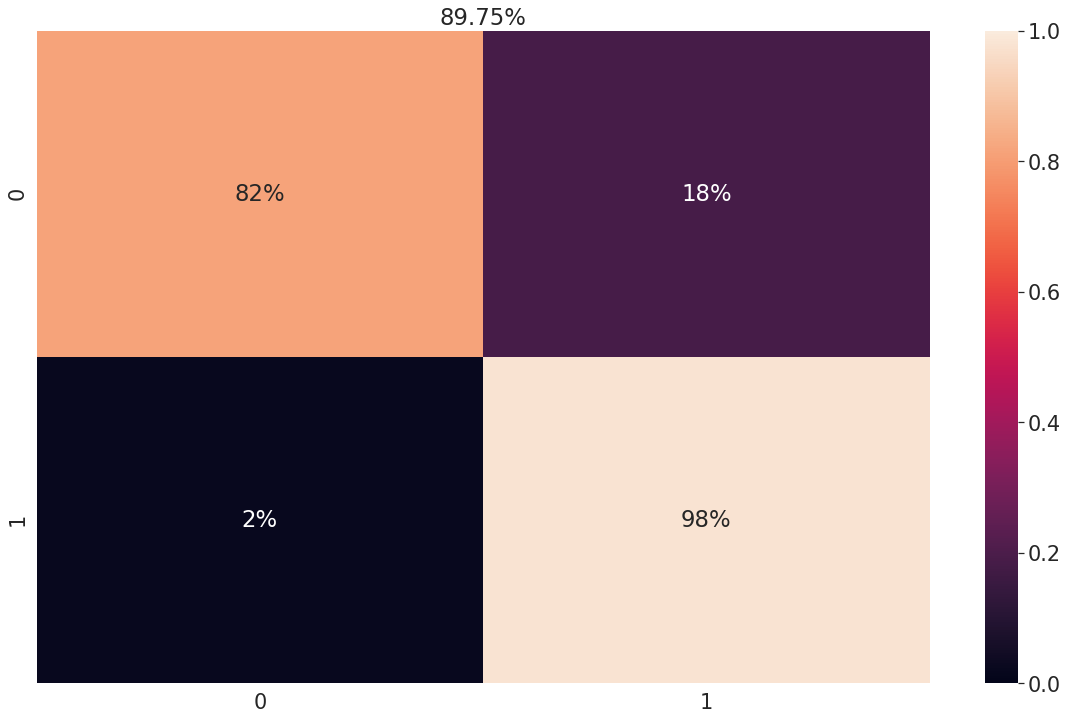

In [16]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize=None)
cm

array([[ 9890,  2228],
       [  286, 13281]])

# ------------------------------------------

In [17]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')

In [18]:
m = extra_df[extra_df.y==0].sample(1000)
s = extra_df[extra_df.y==1].sample(1000)
extra_df = pd.concat([m,s]).reset_index(drop=True)

In [19]:
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [20]:
df_out = get_all_preds(model, extra_dataloader, dataframe=True, final_nodes=2)

100%|██████████| 63/63 [00:00<00:00, 68.11it/s] 


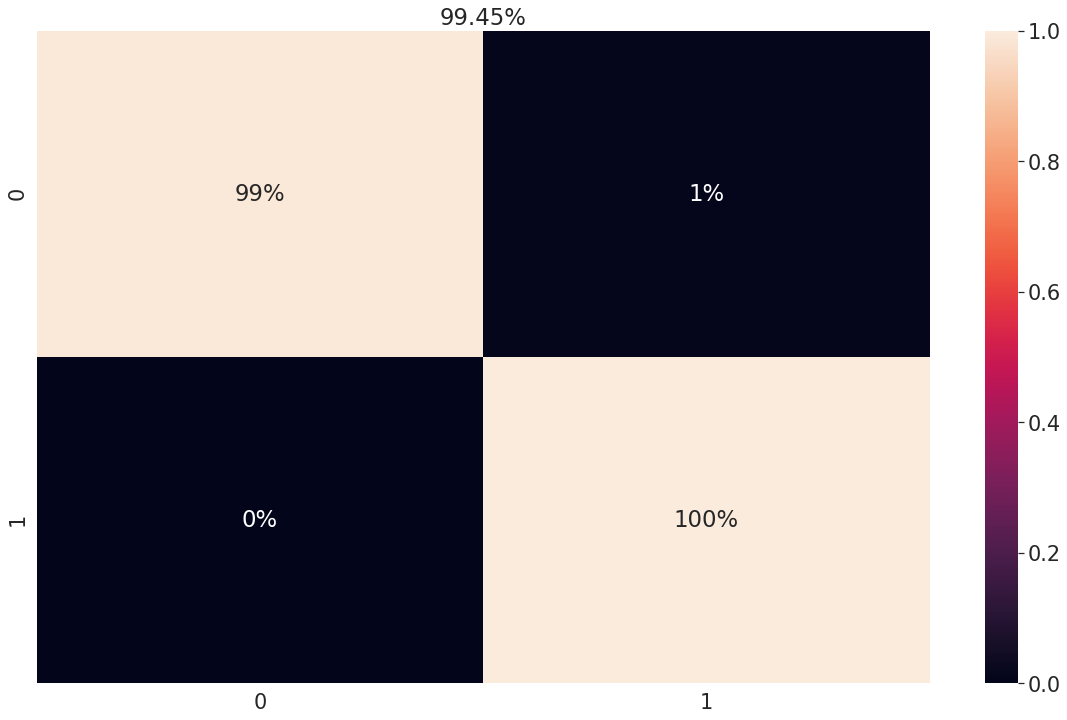

In [21]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')

sns.set(font_scale=1.9)
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, fmt='.0%', vmin=0, vmax=1)
plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");
#plt.savefig("/home/kalfasyan/Dropbox/kuleuven/paper2_figures/confmatsecondary.eps", format='eps', bbox_inches='tight');

In [22]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize=None)
cm

array([[990,  10],
       [  1, 999]])